# Reaction Yield Prediction – Baseline (Buchwald–Hartwig)

This notebook builds a **baseline machine learning model** for predicting reaction yield (%) for **Buchwald–Hartwig C–N coupling reactions**.

We use the **Dreher & Doyle high-throughput experimentation dataset**, originally published in *Science (2018)* and provided as part of the open-source [`rxn_yields`](https://github.com/rxn4chemistry/rxn_yields) dataset.

### **What we do in this baseline:**
1. Load the original Excel dataset of 4 reaction components:
   - **Ligand**
   - **Additive**
   - **Base**
   - **Aryl halide**
   - **+ Yield (%)**

2. Convert components into a **full reaction SMILES** using the official `generate_buchwald_hartwig_rxns()` function from `rxn_yields`.

3. Convert reaction SMILES to **Morgan fingerprints** (RDKit circular fingerprints).

4. Train a **Random Forest Regressor** as a first benchmark.

5. Report **MAE** and **R²** on a 20% test split.

6. Visualize **which fingerprint bits** contribute most to the model.

### **Why this baseline matters**
This establishes:
- a **real-world dataset** (HTE Buchwald–Hartwig),
- a **chemically meaningful representation** (Morgan FP),
- and a **simple but strong classical ML baseline**.

Future improvements can later include:
- reaction BERT models (RXNBERT),
- graph neural networks,
- solvent/ligand learned embeddings,
- hyperparameter tuning,
- uncertainty estimation.

This notebook is **simple** by intention, reproducible, and great for building intuition before moving to advanced models.


## 1. Load data

In [14]:
import sys, os

# get ABSOLUTE PATH to the directory *containing* rxn_yields/
package_parent = os.path.abspath("../")
sys.path.append(package_parent)

print("ADDED TO PATH:", package_parent)


ADDED TO PATH: /Users/tonyodhiambo/Desktop/Comp Chem/reaction-yield-ml


In [15]:
from pathlib import Path

# add project root (one level up from notebooks/) to Python path
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)


Project root: /Users/tonyodhiambo/Desktop/Comp Chem/reaction-yield-ml


In [16]:
import pandas as pd
from pathlib import Path
from src.features import load_reaction_data, encode_features
from datasets import load_dataset
import requests

# Load the dataset
data_path = (Path("/Users/tonyodhiambo/Desktop/Comp Chem/reaction-yield-ml/data/Dreher_and_Doyle_input_data.xlsx"))

df_raw = pd.read_excel(data_path, sheet_name="FullCV_01")
df_raw.head()

,Ligand,Additive,Base,Aryl halide,Output
0,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,CC1=CC(C)=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,ClC1=NC=CC=C1,70.410458
1,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,O=C(OC)C1=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,BrC1=NC=CC=C1,11.064457
2,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)...,O=C(OC)C1=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,IC1=CC=C(CC)C=C1,10.223550
3,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)...,CCOC(C1=CON=C1)=O,CN1CCCN2C1=NCCC2,ClC1=CC=C(C(F)(F)F)C=C1,20.083383
4,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,CC1=CC(C)=NO1,CN1CCCN2C1=NCCC2,ClC1=CC=C(OC)C=C1,0.492663


## 2. Explore features and target

In [17]:
import sys
sys.path.insert(0, '/Users/tonyodhiambo/Desktop/Comp Chem')
from rxn_yields.rxn_yields.data import generate_buchwald_hartwig_rxns
rxns = generate_buchwald_hartwig_rxns(df_raw)

print(rxns)

['Clc1ccccn1.Cc1ccc(N)cc1.O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F)(F)F.COc1ccc(OC)c(P([C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)[C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.Cc1cc(C)on1>>Cc1ccc(Nc2ccccn2)cc1', 'Brc1ccccn1.Cc1ccc(N)cc1.O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F)(F)F.COc1ccc(OC)c(P([C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)[C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COC(=O)c1ccno1>>Cc1ccc(Nc2ccccn2)cc1', 'CCc1ccc(I)cc1.Cc1ccc(N)cc1.O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F)(F)F.CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.COC(=O)c1ccno1>>CCc1ccc(Nc2ccc(C)cc2)cc1', 'FC(F)(F)c1ccc(Cl)cc1.Cc1ccc(N)cc1.O=S(=O)([O][Pd]1[c]2ccccc2-c2ccccc2[NH2]~1)C(F)(F)F.COc1ccc(OC)c(P(C(C)(C)C)C(C)(C)C)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C.CN1CCCN2CCCN=C12.CCOC(=O)c1cnoc1>>Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1', 'COc1ccc(

In [18]:
import pandas as pd

df = df_raw.copy()
df["rxn_smiles"] = rxns

# Target column is Output
df["yield"] = df["Output"]

df = df[["rxn_smiles", "yield"]]
df.head()


,rxn_smiles,yield
0,Clc1ccccn1.Cc1ccc(N)cc1.O=S(=O)([O][Pd]1[c]2cc...,70.410458
1,Brc1ccccn1.Cc1ccc(N)cc1.O=S(=O)([O][Pd]1[c]2cc...,11.064457
2,CCc1ccc(I)cc1.Cc1ccc(N)cc1.O=S(=O)([O][Pd]1[c]...,10.223550
3,FC(F)(F)c1ccc(Cl)cc1.Cc1ccc(N)cc1.O=S(=O)([O][...,20.083383
4,COc1ccc(Cl)cc1.Cc1ccc(N)cc1.O=S(=O)([O][Pd]1[c...,0.492663


In [19]:
df.describe()

,yield
count,3955.000000
mean,33.085259
std,27.291205
min,0.000000
25%,7.877560
50%,28.761729
75%,53.278687
max,99.999990


<Axes: >

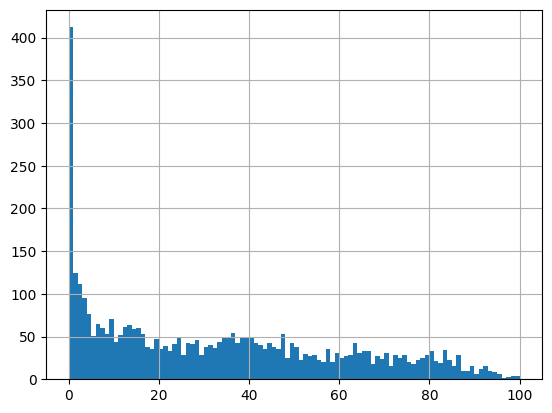

In [20]:
df["yield"].hist(bins=100)

# 3. Morgan Fingerprints

In [21]:
from rdkit import Chem
from rdkit.Chem import AllChem  # still ok to keep
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import numpy as np

morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)


def rxn_to_fp(rxn_smiles):
    # use reactants as input
    reactants = rxn_smiles.split(">")[0]
    mol = Chem.MolFromSmiles(reactants)
    fp = morgan_gen.GetFingerprint(mol)      # RDKit ExplicitBitVect
    return np.array(fp)                      # convert to numpy array


df["fp"] = df["rxn_smiles"].apply(rxn_to_fp)


## 4. Train model

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

X = np.stack(df["fp"].values)
y = df["yield"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MAE: 4.418604181206672
R²: 0.9440078478276362


# 5. Feature Importance

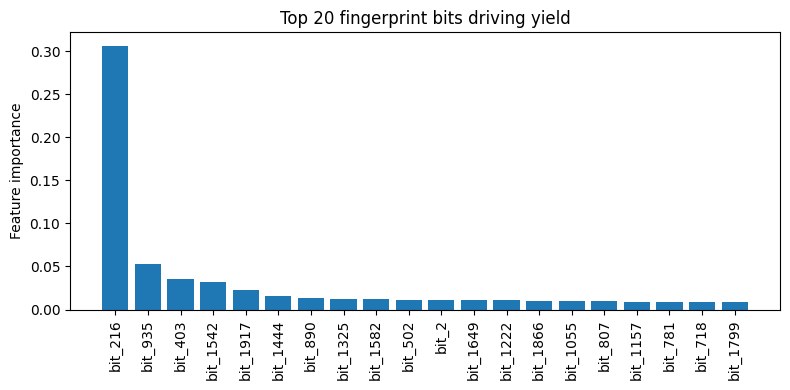

In [23]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:20]  # top 20 bits

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [f"bit_{i}" for i in idx], rotation=90)
plt.ylabel("Feature importance")
plt.title("Top 20 fingerprint bits driving yield")
plt.tight_layout()
plt.show()
